# Initial Model Evaluation

The first model doesn't fulfill all of the project requirements, since it only has two features and we need to address at least three of the expert claims.  But before we try to address any more claims, are we sure about our coefficients so far?

I'm going to use the guideline of [this Duke professor's website](http://people.duke.edu/~rnau/testing.htm), which I interpret as highlighting:

 - linearity
 - statistical independence (of features)
 - homoscedasticity (of residuals)
 - normality (of residuals)

## Linearity
*Are the input variables linear with respect to the output variable?*

I'm going to inspect this with visually plotting them to see if it looks more like a line than a curve

matplotlib wasn't working in Jupyter Lab until I ran:
```
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install jupyter-matplotlib
conda install widgetsnbextension
jupyter nbextension enable --py widgetsnbextension
```
in the terminal

In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd

from src.modeling import modeling
from src.data import sql_utils

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

Pulling the code back out of the .py file to work with it piece by piece

In [5]:
sales_df = sql_utils.create_sales_df()

# perform transformations in preparation for modeling
modeling.transform_wfntlocation(sales_df)

# extract target (sale price)
y = sales_df["saleprice"]

# extract features
X = sales_df[[
    "wfntlocation", 
    "sqfttotliving"
    ]]
X = sm.add_constant(X)

model = sm.OLS(y, X)

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Linearity of each feature individually

In [6]:
fig1, ax1 = plt.subplots(1,2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
ax1[0].scatter(x=X["wfntlocation"], y=y, color="blue", alpha=0.2)

In [8]:
ax1[0].set(xlabel="Waterfront Location", ylabel="Sale Price")

[Text(73.84722222222221, 0.5, 'Sale Price'),
 Text(0.5, 18.242222222222217, 'Waterfront Location')]

In [9]:
ax1[1].scatter(x=X["sqfttotliving"], y=y, color="blue", alpha=0.2)

In [ ]:
ax[1].set(xlabel="Square Feet of Total Living Space", ylabel="Sale Price")

In [ ]:
y.describe()

In [10]:
ax1[0].set_ylim([0, 26750000])

(0, 26750000)

Ok, I'm reminded that I find plotting really annoying.  I can't get the alpha values to actually reveal anything to me here (later note: restarting the kernel seemed to help with this).  And these plots don't look 100% linear but they also don't have any other noticeable curvature

### Linearity of Model Overall

In [11]:
results = model.fit()

In [12]:
y_hat = results.predict()

In [13]:
fig2, ax2 = plt.subplots()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
ax2.scatter(x=y_hat, y=y)

In [15]:
ax2.set(xlabel="Predicted Price", ylabel="Actual Price")

[Text(73.84722222222221, 0.5, 'Actual Price'),
 Text(0.5, 18.242222222222217, 'Predicted Price')]

In [16]:
def abline(slope, intercept):
     """Plot a line from slope and intercept, borrowed from https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib"""
     axes = plt.gca()
     x_vals = np.array(axes.get_xlim())
     y_vals = intercept + slope * x_vals
     plt.plot(x_vals, y_vals, '--')

In [17]:
# plot the line where predicted perfectly matches actual
abline(1,0)

Again, I'm having a hard time interpreting this so far, since the model is not doing a great job of predicting

Let's look at linearity overall, with a Harvey Collier test (hypothesis test where "The Null hypothesis is that the regression is correctly modeled as linear.")

In [18]:
from statsmodels.stats.diagnostic import linear_harvey_collier
print(linear_harvey_collier(results))

LinAlgError: Singular matrix

According to [this blog post](https://boostedml.com/2018/08/testing-linear-regression-assumptions-the-kaggle-housing-price-dataset.html), this error means that at least one feature is "completely linearly determined" by others

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [20]:
vif.round(1)

,VIF Factor,features
0,5.7,const
1,1.0,wfntlocation
2,1.0,sqfttotliving


Ok so my interpretation of this is that none of my features are highly colinear, so there is something else wrong with how I'm trying to run the Harvey Collier test

Maybe the source code will help?
https://github.com/statsmodels/statsmodels/blob/master/statsmodels/sandbox/stats/diagnostic.py#L901

No, I'm finding this too hard to read

Try another test for linearity from statsmodels?

In [21]:
from statsmodels.stats.diagnostic import linear_rainbow
print(linear_rainbow(results))

(1.1968751018163049, 1.1406668612287366e-28)


Well, that ran!  And it indicates that our model is not currently passing the test of linearity (with a p < 0.001)

## Statistical Independence

We actually already ran a test for this!  Results are in the VIF dataframe.

In [22]:
vif.round(1)

,VIF Factor,features
0,5.7,const
1,1.0,wfntlocation
2,1.0,sqfttotliving


Rule of thumb seems to be that VIF <= 10 is acceptable, <= 5 is good.  I don't entirely know what to make of the constant term having the highest VIF.

I interpret this to mean that the Waterfront Location and Square Feet Total Living Space features are sufficiently independent, and it's time to add more features.

## Homoscedasticity

Ideally, the variance in the error terms is not related to the magnitude of the prediction.  We don't actually know the true errors but we use residuals as a representation.

First, visually inspect

In [23]:
fix3, ax3 = plt.subplots()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
# y and y_hat were declared earlier in the notebook
ax3.scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2)

In [25]:
ax3.set(xlabel="Predicted Sale Price", ylabel="Residuals (Actual - Predicted Sale Price)")

[Text(62.222222222222214, 0.5, 'Residuals (Actual - Predicted Sale Price)'),
 Text(0.5, 18.242222222222217, 'Predicted Sale Price')]

This looks decently flat until about \\$250k, then errors seem to get much worse for higher values.  There is also a weird spike right around \\$125k

So, I would say this does not pass the visual inspection for homoscedasticity

Second, let's do a formal statistical test

In [26]:
from statsmodels.stats.diagnostic import het_breuschpagan
lagrange_multiplier, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(y-y_hat,X)

I believe we only care about the lagrange multiplier p-value (not sure why it gives us 4 things)

In [27]:
lm_pvalue

6.083908853812568e-219

Yep, we can reject the homoscedasticity assumption with p < 0.001

In [33]:
X_without_constant = sales_df[[
    "wfntlocation", 
    "sqfttotliving"
    ]]

In [34]:
lagrange_multiplier, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(y-y_hat,X_without_constant)

In [35]:
lm_pvalue

3.8061244651023118e-236

I'm not 100% certain whether the constant term should be there, but either way we can reject homoscedasticity assumption

**Next steps for homoscedasticity:** there is probably something wrong with the target variable, so I probably need to log transform it.  This is annoying because it adds an extra step to any interpretation of coefficients, but it should address this issue

## Normality

We want the errors to be normally distributed (and again, will use the residuals as a proxy)

First, visually inspect

In [28]:
fig4, ax4 = plt.subplots()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
prob_plot = sm.ProbPlot(results.resid)

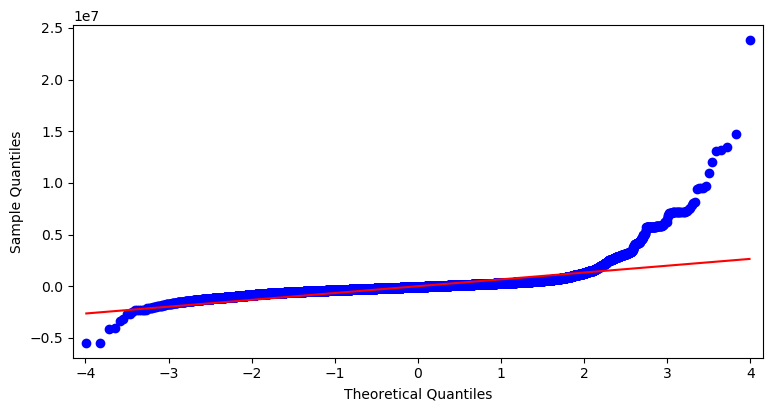

In [30]:
prob_plot.qqplot(line="s", ax=ax4)

Looks like more mass in the tails, not fitting the normality assumption

Second, statistically test

In [31]:
from scipy import stats

In [32]:
stats.kstest(results.resid, 'norm')

KstestResult(statistic=0.5733399405351833, pvalue=0.0)

Yes, we can reject the normality assumption

**Next steps for normality:** remove potential outliers, and maybe do some transformations of features or target

## Library Functions

Let's make the tests easier to run on a model with a few lines of code

What do I need for all of these tests?

Linearity

 - y
 - X_without_constant
 - y_hat
 - results
 
Statistical independence

 - X
 
Homoscedasticity

 - y
 - y_hat
 - X

Normality

 - results.resid

In [39]:
sales_df = sql_utils.create_sales_df()

# perform transformations in preparation for modeling
modeling.transform_wfntlocation(sales_df)

# extract target (sale price)
y = sales_df["saleprice"]

# extract features
X_without_constant = sales_df[[
    "wfntlocation", 
    "sqfttotliving"
    ]]
X = sm.add_constant(X_without_constant)

model = sm.OLS(y, X)
results = model.fit()
y_hat = results.predict()

In [37]:
X.shape

(30270, 3)

In [38]:
X.columns

Index(['const', 'wfntlocation', 'sqfttotliving'], dtype='object')

In [40]:
def visualize_feature_linearity(X_without_constant, y):
    num_features = X_without_constant.shape[1]
    fig, ax = plt.subplots(num_features)
    
    for index, feature in enumerate(X_without_constant.columns):
        ax[index].scatter(x=X[feature], y=y, color="blue", alpha=0.2)
        ax[index].set(xlabel=feature, ylabel="Sale Price")
    plt.show()

In [41]:
visualize_feature_linearity(X_without_constant, y)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
modeling.visualize_feature_linearity(X_without_constant, y)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
def visualize_overall_linearity(y, y_hat):
    fig, ax = plt.subplots()
    
    # plot predicted vs actual
    ax.scatter(x=y_hat, y=y, color="blue", alpha=0.2)
    
    # plot the line where predicted equals actual
    # TODO: add a legend explaining the line
    x_vals = y_vals = np.array(ax.get_xlim())
    ax.plot(x_vals, y_vals, '--')
    
    ax.set(xlabel="Predicted Price", ylabel="Actual Price")
    plt.show()

In [47]:
visualize_overall_linearity(y, y_hat)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
modeling.visualize_overall_linearity(y, y_hat)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
message, linearity_p_value = modeling.statistically_analyze_linearity(results)

In [50]:
message

'Violates the linearity assumption'

In [51]:
linearity_p_value

3.1494472350399145e-28

In [52]:
modeling.perform_linearity_checks(X_without_constant, y, y_hat, results)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the linearity assumption', 3.1494472350399145e-28)


Linearity looks good, moving on to independence

In [53]:
X.values

array([[1.00e+00, 0.00e+00, 1.58e+03],
       [1.00e+00, 0.00e+00, 1.25e+03],
       [1.00e+00, 0.00e+00, 1.81e+03],
       ...,
       [1.00e+00, 0.00e+00, 3.03e+03],
       [1.00e+00, 1.00e+00, 1.28e+03],
       [1.00e+00, 0.00e+00, 2.06e+03]])

In [54]:
modeling.visualize_statistical_independence(X)

,VIF Factor,features
0,5.666855,const
1,1.006620,wfntlocation
2,1.006620,sqfttotliving


In [55]:
modeling.perform_independence_checks(X)

   VIF Factor       features
0    5.666855          const
1    1.006620   wfntlocation
2    1.006620  sqfttotliving
('No features violate the independence assumption', {})


Ok, homoscedasticity

In [56]:
modeling.visualize_homoscedasticity(y, y_hat)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [57]:
modeling.statistically_analyze_homoscedasticity(y, y_hat, X_without_constant)

('Violates the homoscedasticity assumption according to the Breusch-Pagan test',
 3.8061244651343927e-236)

In [58]:
modeling.perform_homoscedasticity_checks(y, y_hat, X_without_constant)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 3.8061244651343927e-236)


Normality, last one

In [59]:
modeling.visualize_normality(results)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
modeling.calculate_kolmogorov_smirnov_statistic_p_value(results)

0.0

In [61]:
modeling.perform_normality_checks(results)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


## Moving to a different file

After all that, now I think the model evaluation belongs in its own file, separate from model-building

In [62]:
from src.modeling import model_evaluation

In [63]:
model_evaluation.perform_linearity_checks(X_without_constant, y, y_hat, results)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the linearity assumption according to the rainbow test', 3.1494472350399145e-28)


In [64]:
model_evaluation.perform_independence_checks(X)

   VIF Factor       features
0    5.666855          const
1    1.006620   wfntlocation
2    1.006620  sqfttotliving
('No features violate the independence assumption', {})


In [65]:
model_evaluation.perform_homoscedasticity_checks(y, y_hat, X_without_constant)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 3.8061244651343927e-236)


In [66]:
model_evaluation.perform_normality_checks(results)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


## Testing the full "pipeline"

In [67]:
modeling.build_and_evaluate_model()

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     5927.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        02:15:26   Log-Likelihood:            -4.4862e+05
No. Observations:               30270   AIC:                         8.973e+05
Df Residuals:                   30267   BIC:                         8.973e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.467e+04   9046.797     -2.727

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the linearity assumption according to the rainbow test', 1.0511429339330309e-28)
Performing Independence Checks
   VIF Factor       features
0    5.666855          const
1    1.006620   wfntlocation
2    1.006620  sqfttotliving
('No features violate the independence assumption', {})
Performing Homoscedasticity Checks
   VIF Factor       features
0    5.666855          const
1    1.006620   wfntlocation
2    1.006620  sqfttotliving
('No features violate the independence assumption', {})
Performing Normality Checks


/Users/ehoffman/Development/DS/housing-price-statistical-analysis/src/modeling/model_evaluation.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [68]:
plt.close('all')

In [69]:
modeling.build_and_evaluate_model()

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     5927.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        02:18:35   Log-Likelihood:            -4.4862e+05
No. Observations:               30270   AIC:                         8.973e+05
Df Residuals:                   30267   BIC:                         8.973e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.467e+04   9046.797     -2.727

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the linearity assumption according to the rainbow test', 1.956662781244542e-28)

Performing Independence Checks

   VIF Factor       features
0    5.666855          const
1    1.006620   wfntlocation
2    1.006620  sqfttotliving
('No features violate the independence assumption', {})

Performing Homoscedasticity Checks

   VIF Factor       features
0    5.666855          const
1    1.006620   wfntlocation
2    1.006620  sqfttotliving
('No features violate the independence assumption', {})

Performing Normality Checks



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [70]:
plt.close('all')

In [71]:
modeling.build_and_evaluate_model()

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     5927.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        02:20:11   Log-Likelihood:            -4.4862e+05
No. Observations:               30270   AIC:                         8.973e+05
Df Residuals:                   30267   BIC:                         8.973e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.467e+04   9046.797     -2.727

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the linearity assumption according to the rainbow test', 1.130749613639495e-28)

Performing Independence Checks

   VIF Factor       features
0    5.666855          const
1    1.006620   wfntlocation
2    1.006620  sqfttotliving
('No features violate the independence assumption', {})

Performing Homoscedasticity Checks



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 3.8061244653138645e-236)

Performing Normality Checks



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)
